In [1]:
import numpy as np
from scipy.optimize import minimize

In [2]:
# ##############################################################################
# LoadData takes the file location for the yacht_hydrodynamics.data and returns
# the data set partitioned into a training set and a test set.
# the X matrix, deal with the month and day strings.
# Do not change this function!
# ##############################################################################
def loadData(df):
    data = np.loadtxt(df)
    Xraw = data[:,:-1]
    # The regression task is to predict the residuary resistance per unit weight of displacement
    yraw = (data[:,-1])[:, None]
    X = (Xraw-Xraw.mean(axis=0))/np.std(Xraw, axis=0)
    y = (yraw-yraw.mean(axis=0))/np.std(yraw, axis=0)

    ind = range(X.shape[0])
    test_ind = ind[0::4] # take every fourth observation for the test set
    train_ind = list(set(ind)-set(test_ind))
    X_test = X[test_ind]
    X_train = X[train_ind]
    y_test = y[test_ind]
    y_train = y[train_ind]

    return X_train, y_train, X_test, y_test

In [3]:
# ##############################################################################
# Returns a single sample from a multivariate Gaussian with mean and cov.
# ##############################################################################
def multivariateGaussianDraw(mean, cov):
    
    #n = mean.shape[0]
    #sample = np.zeros((mean.shape[0], 1)) # This is only a placeholder
    # Task 2:
    # TODO: Implement a draw from a multivariate Gaussian here
    
#     K = np.linalg.cholesky(cov + 1e-15*np.eye(n))
#     sample = np.dot(L, np.random.normal(size=(n,1)))
    sample = np.random.multivariate_normal(mean, cov, 1)

    # Return drawn sample
    return sample

In [4]:
# ##############################################################################
# RadialBasisFunction for the kernel function
# k(x,x') = s2_f*exp(-norm(x,x')^2/(2l^2)). If s2_n is provided, then s2_n is
# added to the elements along the main diagonal, and the kernel function is for
# the distribution of y,y* not f, f*.
# ##############################################################################
class RadialBasisFunction():
    def __init__(self, params):
        self.ln_sigma_f = params[0]
        self.ln_length_scale = params[1]
        self.ln_sigma_n = params[2]

        self.sigma2_f = np.exp(2*self.ln_sigma_f)
        self.sigma2_n = np.exp(2*self.ln_sigma_n)
        self.length_scale = np.exp(self.ln_length_scale)

    def setParams(self, params):
        self.ln_sigma_f = params[0]
        self.ln_length_scale = params[1]
        self.ln_sigma_n = params[2]

        self.sigma2_f = np.exp(2*self.ln_sigma_f)
        self.sigma2_n = np.exp(2*self.ln_sigma_n)
        self.length_scale = np.exp(self.ln_length_scale)

    def getParams(self):
        return np.array([self.ln_sigma_f, self.ln_length_scale, self.ln_sigma_n])

    def getParamsExp(self):
        return np.array([self.sigma2_f, self.length_scale, self.sigma2_n])

    # ##########################################################################
    # covMatrix computes the covariance matrix for the provided matrix X using
    # the RBF. If two matrices are provided, for a training set and a test set,
    # then covMatrix computes the covariance matrix between all inputs in the
    # training and test set.
    # ##########################################################################
    def covMatrix(self, X, Xa=None):
        if Xa is not None:
            X_aug = np.zeros((X.shape[0]+Xa.shape[0], X.shape[1]))
            X_aug[:X.shape[0], :X.shape[1]] = X
            X_aug[X.shape[0]:, :X.shape[1]] = Xa
            X=X_aug

        n = X.shape[0]
        covMat = np.zeros((n,n))

        # Task 1:
        # TODO: Implement the covariance matrix here
        
        
        for i in range(n):
            for j in range(n):
                sqdist = np.exp(-0.5 * (1/(self.length_scale)**2)* (np.linalg.norm(X[i,:]-X[j,:]))**2)
                covMat[i,j] = self.sigma2_f *  sqdist
        
        

        # If additive Gaussian noise is provided, this adds the sigma2_n along
        # the main diagonal. So the covariance matrix will be for [y y*]. If
        # you want [y f*], simply subtract the noise from the lower right
        # quadrant.
        if self.sigma2_n is not None:
            covMat += self.sigma2_n*np.identity(n)

        # Return computed covariance matrix
        return covMat

In [5]:
# ln_sigma_f = np.log(1.27)
# ln_length_scale = np.log(1)
# ln_sigma_n = np.log(0.3)
# basis = RadialBasisFunction([ln_sigma_f,ln_length_scale,ln_sigma_n])
# X = np.array([-1.50,-1.00,-0.7,-0.40, -0.25, 0.00]).reshape(-1,1)

In [6]:
#np.linalg.det(basis.covMatrix(X))

In [7]:
#X_train, y_train, X_test, y_test = loadData('yacht_hydrodynamics.data')

In [8]:
#basis = RadialBasisFunction([ 1.10442998 ,17.38230593 ,-10.10133779])

In [9]:
#np.linalg.det(basis.covMatrix(X_train))

In [10]:
class GaussianProcessRegression():
    def __init__(self, X, y, k):
        self.X = X
        self.n = X.shape[0]
        self.y = y
        self.k = k
        self.K = self.KMat(self.X)
        self.L = np.linalg.cholesky(self.K)

    # ##########################################################################
    # Recomputes the covariance matrix and the inverse covariance
    # matrix when new hyperparameters are provided.
    # ##########################################################################
    def KMat(self, X, params=None):
        if params is not None:
            self.k.setParams(params)
        K = self.k.covMatrix(X)
        self.K = K
        self.L = np.linalg.cholesky(self.K)
        return K

    # ##########################################################################
    # Computes the posterior mean of the Gaussian process regression and the
    # covariance for a set of test points.
    # NOTE: This should return predictions using the 'clean' (not noisy) covariance
    # ##########################################################################
    def predict(self, Xa):
        mean_fa = np.zeros((Xa.shape[0], 1))
        mean_fa = np.array(mean_fa.flatten())
        cov_fa = np.zeros((Xa.shape[0], Xa.shape[0]))
        # Task 3:
        # TODO: compute the mean and covariance of the prediction
        
        
        #beginning of my solution: ------->
        na = Xa.shape[0]
        Ktotal = self.k.covMatrix(self.X, Xa)
        # Covariance between training sample points (without Gaussian noise)
        Kxx = Ktotal[0:self.n,0:self.n] # + 1 * np.eye(10) if there is  Gaussian noise
        
        # Covariance between training and test points
        Kxs = Ktotal[self.n:self.n+na, 0:self.n]
        
        # Covariance between test points
        Kss = Ktotal[self.n:self.n+na,self.n:self.n+na]
        
        # The mean of the GP fit (note that @ is matrix multiplcation: A @ B is equivalent to np.matmul(A,B))
        mean = Kxs @ np.linalg.inv(Kxx) @ self.y
        
        for i in range(mean.shape[0]):
            mean_fa[i] = (mean[i])[0]
        # The covariance matrix of the GP fit
        cov_fa = Kss - Kxs @ np.linalg.inv(Kxx) @ Kxs.T
        

        # Return the mean and covariance
        return mean_fa, cov_fa

    # ##########################################################################
    # Return negative log marginal likelihood of training set. Needs to be
    # negative since the optimiser only minimises.
    # ##########################################################################
    def logMarginalLikelihood(self, params=None):
        if params is not None:
            self.KMat(self.X, params)

        mll = 0
        # Task 4:
        # TODO: Calculate the log marginal likelihood ( mll ) of self.y
        
        mll = 0.5* (self.y).T @ np.linalg.solve((self.L).T, np.linalg.solve(self.L, self.y)) + np.log(np.sum((self.L).diagonal())) + 0.5 * self.n * np.log(2 * np.pi)

        # Return mll
        return mll

    # ##########################################################################
    # Computes the gradients of the negative log marginal likelihood wrt each
    # hyperparameter.
    # ##########################################################################
    def gradLogMarginalLikelihood(self, params=None):
        if params is not None:
            K = self.KMat(self.X, params)

        grad_ln_sigma_f = grad_ln_length_scale = grad_ln_sigma_n = 0
        # Task 5:
        # TODO: calculate the gradients of the negative log marginal likelihood
        # wrt. the hyperparameters
        
        beta_ln_length_scale = np.zeros((self.n, self.n))
        beta_ln_sigma_f = np.zeros((self.n, self.n))
        beta_ln_sigma_n = np.zeros((self.n, self.n))
        
        param = self.k.getParamsExp()
        
        
        alpha = np.linalg.solve(self.K, self.y)
        #inv = np.linalg.solve((self.L).T, np.linalg.solve(self.L, np.eye(self.n,self.n)))
        inv = np.linalg.inv(self.K)
        #L = self.L
        for i in range(self.n):
            for j in range(self.n):
                beta_ln_length_scale[i,j] = (1/(param[1]**2)) * ((np.linalg.norm(self.X[i]-self.X[j]))**2) * param[0] * np.exp(-0.5*(np.linalg.norm(self.X[i]-self.X[j])**2)/(param[1]**2)) 
                beta_ln_sigma_n[i,j] =  2 * param[2] if (i==j) else 0
                beta_ln_sigma_f[i,j] = 2 * param[0] * (np.exp(-0.5*(np.linalg.norm(self.X[i]-self.X[j])**2)/(param[1]**2)))
        
        #beta_ln_sigma_n =beta_ln_sigma_n @ 
        grad_ln_sigma_f = -0.5 * np.trace((alpha @ alpha.T - inv) @ beta_ln_sigma_f)
        grad_ln_length_scale = -0.5 * np.trace((alpha @ alpha.T - inv) @ beta_ln_length_scale)
        grad_ln_sigma_n = -0.5 * np.trace((alpha @ alpha.T - inv) @ beta_ln_sigma_n)
        

        # Combine gradients
        gradients = np.array([grad_ln_sigma_f, grad_ln_length_scale, grad_ln_sigma_n])

        # Return the gradients
        return gradients

    # ##########################################################################
    # Computes the mean squared error between two input vectors.
    # ##########################################################################
    def mse(self, ya, fbar):
        mse = 0
        # Task 7:
        # TODO: Implement the MSE between ya and fbar
        
        mse = np.sum((ya[i,:] - fbar[i,:])**2)/(ya.shape[0])

        # Return mse
        return mse

    # ##########################################################################
    # Computes the mean standardised log loss.
    # ##########################################################################
    def msll(self, ya, fbar, cov):
        msll = 0
        # Task 7:
        # TODO: Implement MSLL of the prediction fbar, cov given the target ya

        return msll

    # ##########################################################################
    # Minimises the negative log marginal likelihood on the training set to find
    # the optimal hyperparameters using BFGS.
    # ##########################################################################
    def optimize(self, params, disp=True):
        
        #params = np.array([0.5*np.log(1.0), np.log(1.0), 0.5*np.log(0.5)])
        res = minimize(self.logMarginalLikelihood, params, method ='BFGS', jac = self.gradLogMarginalLikelihood, options = {'disp':disp})
        return res.x

if __name__ == '__main__':

    np.random.seed(42)

    ##########################
    # You can put your tests here - marking
    # will be based on importing this code and calling
    # specific functions with custom input.
    ##########################

In [11]:
X_train, y_train, X_test, y_test = loadData('yacht_hydrodynamics.data')
params = [0.5*np.log(1.0), np.log(0.1), 0.5*np.log(0.5)]
basis = RadialBasisFunction(params)

In [12]:
basis.sigma2_f

1.0

In [13]:
GPR = GaussianProcessRegression(X_train, y_train,basis)

In [14]:
basis.covMatrix(X_train)

array([[1.50000000e+000, 4.61008875e-002, 4.51686537e-006, ...,
        4.26469604e-314, 0.00000000e+000, 0.00000000e+000],
       [4.61008875e-002, 1.50000000e+000, 4.61008875e-002, ...,
        1.04571091e-288, 4.26469604e-314, 0.00000000e+000],
       [4.51686537e-006, 4.61008875e-002, 1.50000000e+000, ...,
        5.44946378e-266, 1.04571091e-288, 4.26469604e-314],
       ...,
       [4.26469604e-314, 1.04571091e-288, 5.44946378e-266, ...,
        1.50000000e+000, 4.61008875e-002, 4.51686537e-006],
       [0.00000000e+000, 4.26469604e-314, 1.04571091e-288, ...,
        4.61008875e-002, 1.50000000e+000, 4.61008875e-002],
       [0.00000000e+000, 0.00000000e+000, 4.26469604e-314, ...,
        4.51686537e-006, 4.61008875e-002, 1.50000000e+000]])

In [15]:
(basis.covMatrix(X_train, X_test)).shape

(308, 308)

In [16]:
(GPR.KMat(X_train)).shape

(231, 231)

In [17]:
mean, cov = GPR.predict(X_test)

In [18]:
mean.shape

(77,)

In [19]:
cov.shape

(77, 77)

In [20]:
GPR.logMarginalLikelihood()

array([[302.99403655]])

In [21]:
GPR.gradLogMarginalLikelihood()

array([ 39.27007743, -11.97860468,  21.58116714])

In [49]:
sample = multivariateGaussianDraw(mean, cov)

In [34]:
mean = [0, 0]
cov = [[1, 0], [0, 100]]  

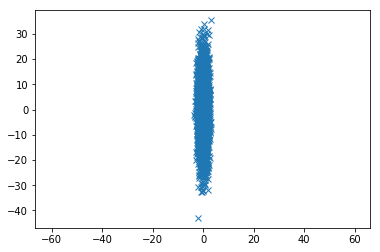

In [37]:
import matplotlib.pyplot as plt
x, y = np.random.multivariate_normal(mean, cov, 5000).T
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()

In [23]:
sigma2_f = np.exp(2*0.5*np.log(1.0))
length_scale= np.exp(np.log(0.1))
sigma2_n = np.exp(2*0.5*np.log(0.5))

In [24]:
def covariance(X,length_scale,sigma2_n,sigma2_f):
    n = X.shape[0]
    covMat = np.zeros((n,n))
    for i in range(n):
            for j in range(n):
                sqdist = np.exp(-0.5 * (1/(length_scale)**2)* (np.linalg.norm(X[i,:]-X[j,:]))**2)
                covMat[i,j] = sigma2_f *  sqdist
                
    
    covMat += sigma2_n*np.identity(n)
    
    return covMat

In [25]:
def mll(X,y,length_scale,sigma2_n,sigma2_f):
    n = X.shape[0]
    K = covariance(X,length_scale,sigma2_n,sigma2_f)
    L = np.linalg.cholesky(K)
    mll = 0.5* y.T @ np.linalg.solve(L.T, np.linalg.solve(L, y)) + np.log(np.sum(L.diagonal())) + 0.5 * n * np.log(2 * np.pi)
    
    return mll

In [26]:
# def gradient_checker():
#     pass

In [28]:
covariance(X_train,length_scale,sigma2_n,sigma2_f).shape

(231, 231)

In [48]:
h = 1e-6
Gsigmaf_h = mll(X_train,y_train,length_scale,sigma2_n,sigma2_f + h)
Gsigmaf = mll(X_train,y_train,length_scale,sigma2_n,sigma2_f)

In [49]:
(Gsigmaf_h - Gsigmaf)/h

array([[-56.98667826]])

In [50]:
mll(X_train,y_train,length_scale,sigma2_n,sigma2_f)

array([[302.99403655]])

In [51]:
Gsigman_h = mll(X_train,y_train,length_scale,sigma2_n+h,sigma2_f)
Gsigman = mll(X_train,y_train,length_scale,sigma2_n,sigma2_f)

In [52]:
(Gsigman_h - Gsigman)/h

array([[-55.17528587]])

In [53]:
Gl_h = mll(X_train,y_train,length_scale + h,sigma2_n,sigma2_f)
Gl = mll(X_train,y_train,length_scale,sigma2_n,sigma2_f)

In [55]:
(Gl_h - Gl)/h

array([[-111.49623032]])

In [43]:
from scipy.optimize import check_grad

In [44]:
check_grad(GPR.logMarginalLikelihood(), GPR.gradLogMarginalLikelihood(), params)

TypeError: 'numpy.ndarray' object is not callable